# Capstone - Craig Perkins


### Intro - [The Great Decoupling](https://hbr.org/2015/06/the-great-decoupling)

As a computer scientist, I often think about the ramifications of automation and what that means for labor in the United States and globally. 2 prominent MIT Economists, Erik Brynjolfsson and Andrew McAfee, coined the term `The Great Decoupling` to describe what they see as a decoupling of labor from productivity. That is to say that as technology improves, we are able to become more productive and produce more value for less input. This is not a new phenomenom. The first industrial revolution also introduced massive productivity gains and saw the birth of many new industries, but economists argue over whether our digital industrial revolution will also give birth to many new industries and jobs, or as many fear, will displace some segments of the labor force altogether and lead to obsolescence. 

For this Capstone I will use data from the Bureau of Labor Statistics, `bls` for short, to try to get some insights into how the labor force is changing and what changes in productivity are being seen.

The capstone will also dive into other questions like seeing the correlation between Air transportation and Accomodations

---

Refer to [Table B-1. Employees on nonfarm payrolls by industry sector and selected industry detail, [in thousands]](https://www.bls.gov/webapps/legacy/cesbtab1.htm) to see how BLS organizes the sectors

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import sklearn
import statsmodels
import seaborn as sns

In [2]:
# Read file into a Pandas DataFrame

from dateutil import parser
import string
import re

filename = "bls_series_seasonally_adjusted.csv"

series_filename = "bls_series_definitions.csv"

# By default read_excel will read in the first sheet
# You can supply the sheet_name kwarg to specify which sheet to read in

all_series = pd.read_csv(filename)

series_definitions = pd.read_csv(series_filename)

# table = pd.read_excel(filename, sheet_name="Sheet1")

# print(table.head(10).to_string(index=False))

# print(table.iloc[[0], 1:])
# print(type(table.iloc[[0], 1:]))
# list(table.columns)


In [3]:
# Join all_series with series_definitions

if 'Series ID' in list(all_series.columns):
    all_series = all_series.set_index('Series ID')

if 'series_id' in list(series_definitions.columns):
    series_definitions = series_definitions.set_index('series_id')

series_with_names = all_series.merge(series_definitions, left_index=True, right_index=True)

print('\n'.join(list(series_with_names['series_title'])))

# sectors_definitions = series_definitions.loc[[
#     'CES0000000001'
# ]]

# print(sectors_definitions)


All employees, thousands, total nonfarm, seasonally adjusted
All employees, thousands, total private, seasonally adjusted
All employees, thousands, goods-producing, seasonally adjusted
All employees, thousands, mining and logging, seasonally adjusted
All employees, thousands, logging, seasonally adjusted
All employees, thousands, mining, seasonally adjusted
All employees, thousands, oil and gas extraction, seasonally adjusted
All employees, thousands, mining, except oil and gas, seasonally adjusted
All employees, thousands, coal mining, seasonally adjusted
All employees, thousands, metal ore mining, seasonally adjusted
All employees, thousands, nonmetallic mineral mining and quarrying, seasonally adjusted
All employees, thousands, support activities for mining, seasonally adjusted
All employees, thousands, construction, seasonally adjusted
All employees, thousands, construction of buildings, seasonally adjusted
All employees, thousands, residential building, seasonally adjusted
All emp

Text(0.5, 0, 'Date')

<Figure size 1152x864 with 0 Axes>

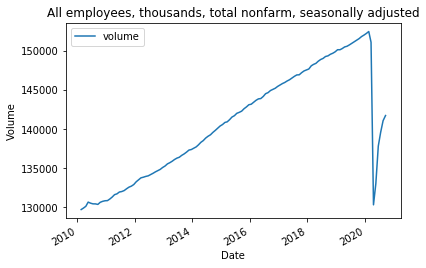

In [4]:
# Plotting Total Non-Farm Payrolls

import matplotlib.pyplot as plt
import seaborn as sns

# Clean one dataset to get it ready to chart


# print(table.iloc[[0], 1:])
bls_columns = list(all_series.columns)
# print(table.iloc[0, 0])
# print(series_definitions.head())
series_def = series_definitions.loc[all_series.index[0]]

# First series is total non-farm payrolls over the last 10 years
nfp_series = all_series.iloc[[0], 1:].T
nfp_series.columns = ['volume']
nfp_series = nfp_series.reset_index().rename(columns={'index': 'period'})

nfp_series['period'] = [parser.parse(d) for d in nfp_series['period']]
# This is done because there are Preliminary and Corrected numbers in the dataset that
# end is (P) and (C) respectively
nfp_series['volume'] = [int(re.sub('\D', '', s) or 0) if type(s) == str else s for s in nfp_series['volume']]

nfp_series = nfp_series[nfp_series['volume'] != 0]

# print(series_def)
# print(nfp_series)

plt.figure(figsize=(16, 12))
nfp_series.plot(x ='period', y='volume', kind = 'line')
plt.title(series_def['series_title'])
plt.ylabel('Volume')
plt.xlabel('Date')

# print(list(bls_series.columns))


In [5]:
# Figure out sector top gaining and top losing sectors

sector_series = all_series.iloc[1:, 1:].T

sector_series = sector_series.reset_index().rename(columns={'index': 'period'})

series_id_to_title_dict = {}
for col in sector_series.columns:
    if col in series_definitions.index:
        row = series_definitions.loc[col]
        series_id_to_title_dict[col] = row['series_title']
        
# print(series_id_to_title_dict)
        
# sector_series = sector_series.rename(columns=series_id_to_title_dict)

sector_series['period'] = [parser.parse(d) for d in sector_series['period']]

for col in sector_series.columns:
    if col == 'period':
        continue
    new_series = []
    for s in sector_series[col]:
        floats = re.findall(r'[\d\.\d]+', str(s))
        if floats:
            new_series.append(float(floats[0]))
        else:
            new_series.append(0)
    sector_series[col] = new_series
    
sector_series = sector_series[(sector_series != 0).all(1)]

# Exclude All employees, thousands, total private, seasonally adjusted and All employees, thousands, private service-providing, seasonally adjusted
# series_id	supersector_code	industry_code	data_type_code	seasonal	series_title
# CES0500000001	5	5000000	1	S	All employees, thousands, total private, seasonally adjusted
# CES0800000001	8	8000000	1	S	All employees, thousands, private service-providing, seasonally adjusted
cols = [col for col in sector_series.columns if col not in ['CES0500000001', 'CES0800000001']]
sector_series = sector_series[cols]
    
first_and_last = sector_series.iloc[[0, -1]]

# print(first_and_last)

diff_df = first_and_last.set_index('period').diff()

# print(diff_df.tail(1))

ten_year_delta = diff_df.tail(1).sort_values(axis=1, by=diff_df.tail(1).index[0], ascending=False)

most_jobs_gained = ten_year_delta[ten_year_delta.columns[0:10]]
most_jobs_lost = ten_year_delta[ten_year_delta.columns[-10:]]

print("Top 10")
for idx, col in enumerate(list(most_jobs_gained.columns)):
    series_def = series_definitions.loc[col]
    print(f"{idx+1}) {series_def['series_title']}")
    print(f"Jobs Change: {list(most_jobs_gained[col])[0]}")
    print("\n")

# max_jobs = diff_df.tail(1).max(axis=1)
# idx_max = diff_df.tail(1).idxmax(axis=1)
# min_jobs = diff_df.tail(1).min(axis=1)
# idx_min = diff_df.tail(1).idxmin(axis=1)

# print(max_jobs)
# print(idx_max[0])
# print(min_jobs)
# print(idx_min)
          
print("\n")
print("Bottom 10")
for idx, col in enumerate(list(most_jobs_lost.columns)):
    series_def = series_definitions.loc[col]
    print(f"{10-idx}) {series_def['series_title']}")
    print(f"Jobs Change: {list(most_jobs_lost[col])[0]}")
    print("\n")


# max_series_def = series_definitions.loc[idx_max[0]]
# min_series_def = series_definitions.loc[idx_min[0]]

# print(f"Max: {max_series_def['series_title']}")
# print(f"Jobs Change: {max_jobs[0]}")

# print('\n')      
      
# print(f"Min: {min_series_def['series_title']}")
# print(f"Jobs Change: {min_jobs[0]}")

Top 10
1) All employees, thousands, professional and business services, seasonally adjusted
Jobs Change: 3573.0


2) All employees, thousands, education and health services, seasonally adjusted
Jobs Change: 3350.0


3) All employees, thousands, health care and social assistance, seasonally adjusted
Jobs Change: 2988.0


4) All employees, thousands, goods-producing, seasonally adjusted
Jobs Change: 2436.0


5) All employees, thousands, trade, transportation, and utilities, seasonally adjusted
Jobs Change: 2266.0


6) All employees, thousands, health care, seasonally adjusted
Jobs Change: 2151.1000000000004


7) All employees, thousands, professional and technical services, seasonally adjusted
Jobs Change: 1920.9000000000005


8) All employees, thousands, construction, seasonally adjusted
Jobs Change: 1745.0


9) All employees, thousands, ambulatory health care services, seasonally adjusted
Jobs Change: 1634.0


10) All employees, thousands, transportation and warehousing, seasonally adj

In [6]:
# Descriptive statistics on all sectors

sector_series = all_series.iloc[1:, 1:].T

sector_series = sector_series.reset_index().rename(columns={'index': 'period'})

sector_series['period'] = [parser.parse(d) for d in sector_series['period']]

series_id_to_title_dict = {}
for col in sector_series.columns:
    if col in series_definitions.index:
        row = series_definitions.loc[col]
        series_id_to_title_dict[col] = f"{col} - {row['series_title']}"
        
# print(series_id_to_title_dict)

for col in sector_series.columns:
    if col == 'period':
        continue
    new_series = []
    for s in sector_series[col]:
        floats = re.findall(r'[\d\.\d]+', str(s))
        if floats:
            new_series.append(float(floats[0]))
        else:
            new_series.append(0)
    sector_series[col] = new_series
    
sector_series = sector_series[(sector_series != 0).all(1)]

sector_series = sector_series.rename(columns=series_id_to_title_dict)

sector_series.describe()

Series ID,"CES0500000001 - All employees, thousands, total private, seasonally adjusted","CES0600000001 - All employees, thousands, goods-producing, seasonally adjusted","CES1000000001 - All employees, thousands, mining and logging, seasonally adjusted","CES1011330001 - All employees, thousands, logging, seasonally adjusted","CES1021000001 - All employees, thousands, mining, seasonally adjusted","CES1021100001 - All employees, thousands, oil and gas extraction, seasonally adjusted","CES1021200001 - All employees, thousands, mining, except oil and gas, seasonally adjusted","CES1021210001 - All employees, thousands, coal mining, seasonally adjusted","CES1021220001 - All employees, thousands, metal ore mining, seasonally adjusted","CES1021230001 - All employees, thousands, nonmetallic mineral mining and quarrying, seasonally adjusted",...,"CES9000000001 - All employees, thousands, government, seasonally adjusted","CES9091000001 - All employees, thousands, federal, seasonally adjusted","CES9091100001 - All employees, thousands, federal, except u.s. postal service, seasonally adjusted","CES9091912001 - All employees, thousands, u.s. postal service, seasonally adjusted","CES9092000001 - All employees, thousands, state government, seasonally adjusted","CES9092161101 - All employees, thousands, state government education, seasonally adjusted","CES9092200001 - All employees, thousands, state government, excluding education, seasonally adjusted","CES9093000001 - All employees, thousands, local government, seasonally adjusted","CES9093161101 - All employees, thousands, local government education, seasonally adjusted","CES9093200001 - All employees, thousands, local government, excluding education, seasonally adjusted"
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,...,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,118457.429688,19408.250000,763.765625,50.742188,712.960937,169.855469,199.284375,65.824219,41.532031,91.934375,...,22170.437500,2823.531250,2212.275781,611.240625,5101.343750,2414.362500,2686.895312,14245.562500,7875.140625,6370.376563
std,6794.491620,1059.437512,82.920841,1.532206,82.487300,20.646694,13.542505,15.074789,2.459529,3.963881,...,306.753453,91.948114,82.121560,18.145720,59.326063,54.369346,28.858334,231.309581,125.120537,121.236407
min,107222.000000,17627.000000,612.000000,47.200000,561.500000,139.900000,177.100000,41.900000,34.900000,85.700000,...,21265.000000,2728.000000,2135.500000,590.200000,4935.000000,2239.500000,2646.900000,13424.000000,7308.000000,6095.600000
25%,112372.750000,18469.250000,698.500000,49.575000,648.025000,152.900000,188.750000,51.600000,39.775000,89.200000,...,21916.750000,2775.750000,2175.950000,598.275000,5055.000000,2380.400000,2671.500000,14064.750000,7796.675000,6269.325000
50%,118734.500000,19545.000000,741.000000,50.750000,692.000000,166.600000,199.150000,65.450000,41.650000,91.400000,...,22172.000000,2806.000000,2197.750000,607.100000,5090.500000,2401.550000,2683.650000,14233.000000,7901.250000,6329.250000
75%,124414.500000,20081.000000,849.250000,51.825000,799.050000,192.525000,208.925000,79.225000,43.700000,95.125000,...,22404.500000,2847.750000,2220.925000,616.100000,5158.250000,2472.750000,2693.700000,14415.250000,7959.150000,6465.975000
max,129718.000000,21205.000000,903.000000,54.500000,851.000000,200.800000,224.500000,89.700000,45.800000,100.200000,...,22996.000000,3416.000000,2757.100000,667.800000,5199.000000,2503.700000,2781.100000,14680.000000,8062.400000,6638.400000


Text(0, 0.5, 'Employment (thousands) - September 2020')

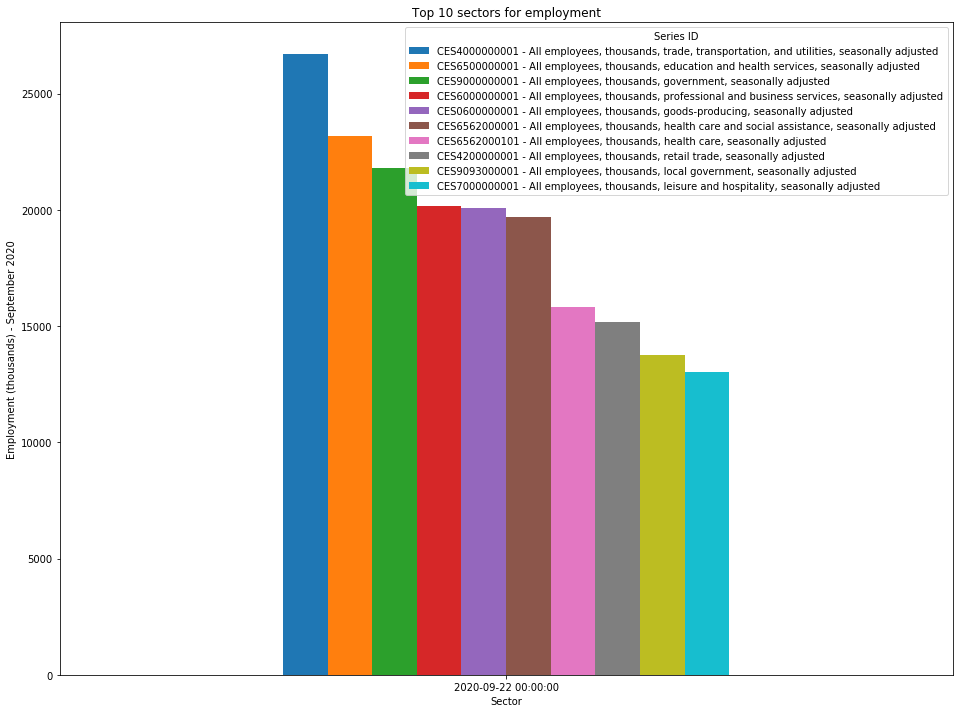

In [7]:
# Bar Plot of latest data point

sector_series = all_series.iloc[1:, 1:].T

sector_series = sector_series.reset_index().rename(columns={'index': 'period'})

sector_series['period'] = [parser.parse(d) for d in sector_series['period']]

series_id_to_title_dict = {}
for col in sector_series.columns:
    if col in series_definitions.index:
        row = series_definitions.loc[col]
        series_id_to_title_dict[col] = f"{col} - {row['series_title']}"
        
# print(series_id_to_title_dict)

for col in sector_series.columns:
    if col == 'period':
        continue
    new_series = []
    for s in sector_series[col]:
        floats = re.findall(r'[\d\.\d]+', str(s))
        if floats:
            new_series.append(float(floats[0]))
        else:
            new_series.append(0)
    sector_series[col] = new_series
    
# Exclude All employees, thousands, total private, seasonally adjusted and All employees, thousands, private service-providing, seasonally adjusted
# series_id	supersector_code	industry_code	data_type_code	seasonal	series_title
# CES0500000001	5	5000000	1	S	All employees, thousands, total private, seasonally adjusted
# CES0800000001	8	8000000	1	S	All employees, thousands, private service-providing, seasonally adjusted
cols = [col for col in sector_series.columns if col not in ['CES0500000001', 'CES0800000001']]
sector_series = sector_series[cols]
    
sector_series = sector_series[(sector_series != 0).all(1)]

last_row = sector_series.tail(1)
last_row = last_row.set_index('period')
last_row = last_row.sort_values(axis=1, by=last_row.index[0], ascending=False)

last_row = last_row.rename(columns=series_id_to_title_dict)

top_10 = last_row[list(last_row.columns)[0:10]]

ax = top_10.plot(kind='bar', rot=0, figsize=(16,12), title="Top 10 sectors for employment")
ax.set_xlabel("Sector")
ax.set_ylabel("Employment (thousands) - September 2020")

Text(0, 0.5, 'Employment (thousands) - September 2020')

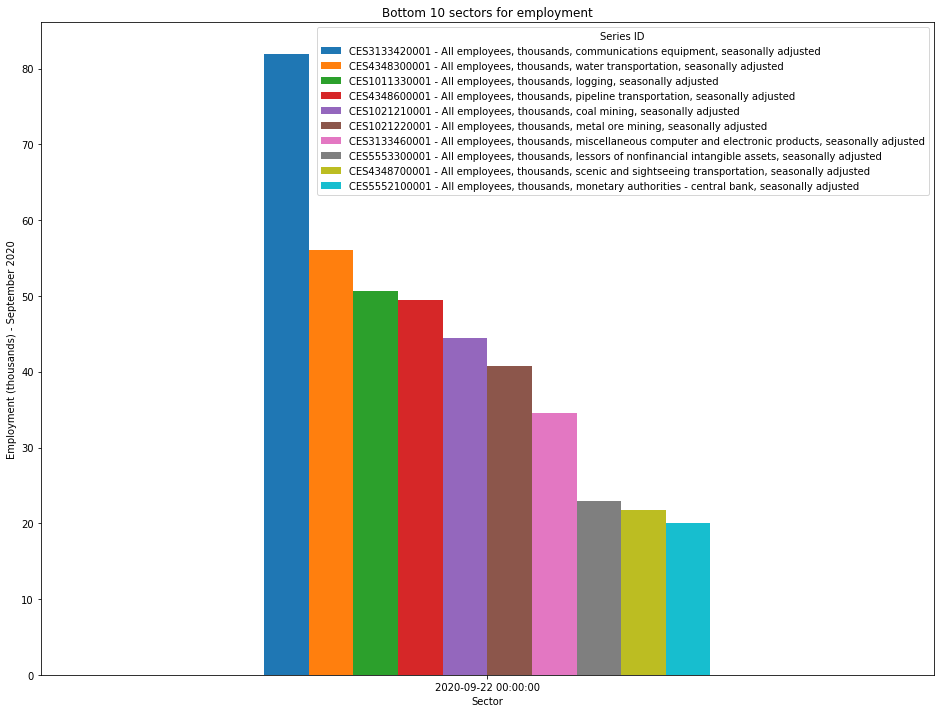

In [8]:
# Bar Plot of latest data point

sector_series = all_series.iloc[1:, 1:].T

sector_series = sector_series.reset_index().rename(columns={'index': 'period'})

sector_series['period'] = [parser.parse(d) for d in sector_series['period']]

series_id_to_title_dict = {}
for col in sector_series.columns:
    if col in series_definitions.index:
        row = series_definitions.loc[col]
        series_id_to_title_dict[col] = f"{col} - {row['series_title']}"
        
# print(series_id_to_title_dict)

for col in sector_series.columns:
    if col == 'period':
        continue
    new_series = []
    for s in sector_series[col]:
        floats = re.findall(r'[\d\.\d]+', str(s))
        if floats:
            new_series.append(float(floats[0]))
        else:
            new_series.append(0)
    sector_series[col] = new_series
    
# Exclude All employees, thousands, total private, seasonally adjusted and All employees, thousands, private service-providing, seasonally adjusted
# series_id	supersector_code	industry_code	data_type_code	seasonal	series_title
# CES0500000001	5	5000000	1	S	All employees, thousands, total private, seasonally adjusted
# CES0800000001	8	8000000	1	S	All employees, thousands, private service-providing, seasonally adjusted
cols = [col for col in sector_series.columns if col not in ['CES0500000001', 'CES0800000001']]
sector_series = sector_series[cols]
    
sector_series = sector_series[(sector_series != 0).all(1)]

last_row = sector_series.tail(1)
last_row = last_row.set_index('period')
last_row = last_row.sort_values(axis=1, by=last_row.index[0], ascending=False)

last_row = last_row.rename(columns=series_id_to_title_dict)

bottom_10 = last_row[list(last_row.columns)[-10:]]

ax = bottom_10.plot(kind='bar', rot=0, figsize=(16,12), title="Bottom 10 sectors for employment")
ax.set_xlabel("Sector")
ax.set_ylabel("Employment (thousands) - September 2020")

Text(0.5, 0, 'Period')

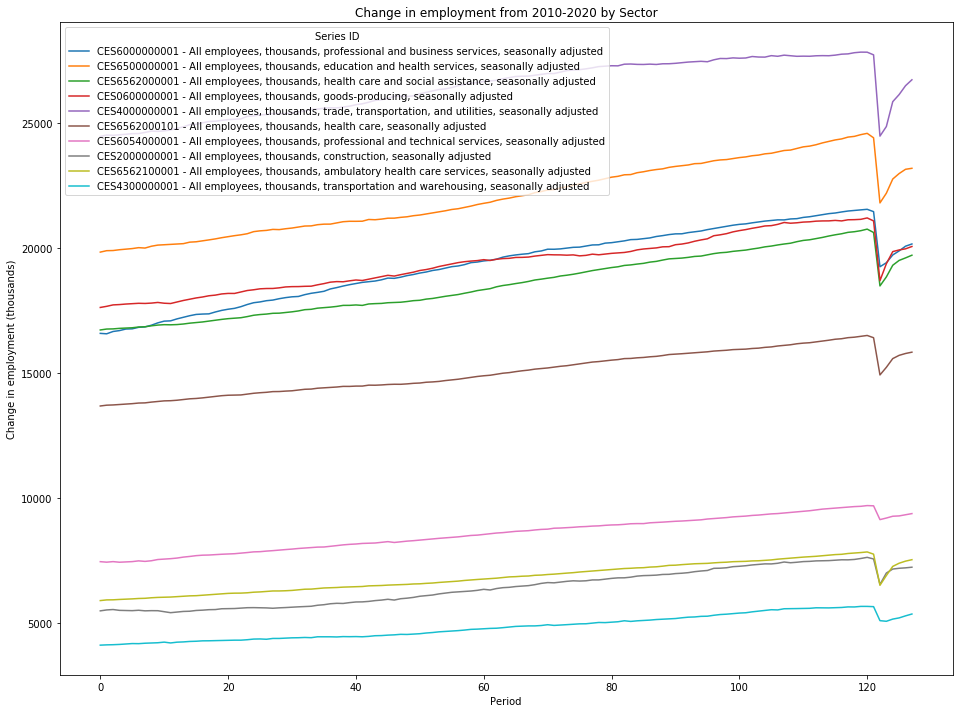

In [9]:
# Line Chart of Top 10 sectors of job gains/losses over the last decade

sector_series = all_series.iloc[1:, 1:].T

sector_series = sector_series.reset_index().rename(columns={'index': 'period'})

sector_series['period'] = [parser.parse(d) for d in sector_series['period']]

series_id_to_title_dict = {}
for col in sector_series.columns:
    if col in series_definitions.index:
        row = series_definitions.loc[col]
        series_id_to_title_dict[col] = f"{col} - {row['series_title']}"
        
# print(series_id_to_title_dict)

for col in sector_series.columns:
    if col == 'period':
        continue
    new_series = []
    for s in sector_series[col]:
        floats = re.findall(r'[\d\.\d]+', str(s))
        if floats:
            new_series.append(float(floats[0]))
        else:
            new_series.append(0)
    sector_series[col] = new_series
    
# Exclude All employees, thousands, total private, seasonally adjusted and All employees, thousands, private service-providing, seasonally adjusted
# series_id	supersector_code	industry_code	data_type_code	seasonal	series_title
# CES0500000001	5	5000000	1	S	All employees, thousands, total private, seasonally adjusted
# CES0800000001	8	8000000	1	S	All employees, thousands, private service-providing, seasonally adjusted
cols = [col for col in sector_series.columns if col not in ['CES0500000001', 'CES0800000001']]
sector_series = sector_series[cols]

sector_series = sector_series[(sector_series != 0).all(1)]

# last_row = sector_series.tail(1)
# last_row = last_row.set_index('period')
# last_row = last_row.sort_values(axis=1, by=last_row.index[0], ascending=False)

# top_10 = sector_series[list(last_row.columns)[0:10]]
top_10 = sector_series[list(most_jobs_gained.columns)]
# top_10 = top_10.set_index('period')
top_10 = top_10.rename(columns=series_id_to_title_dict)

ax = top_10.plot(rot=0, figsize=(16,12), title="Change in employment from 2010-2020 by Sector")
ax.set_ylabel("Change in employment (thousands)")
ax.set_xlabel("Period")

Text(0.5, 0, 'Period')

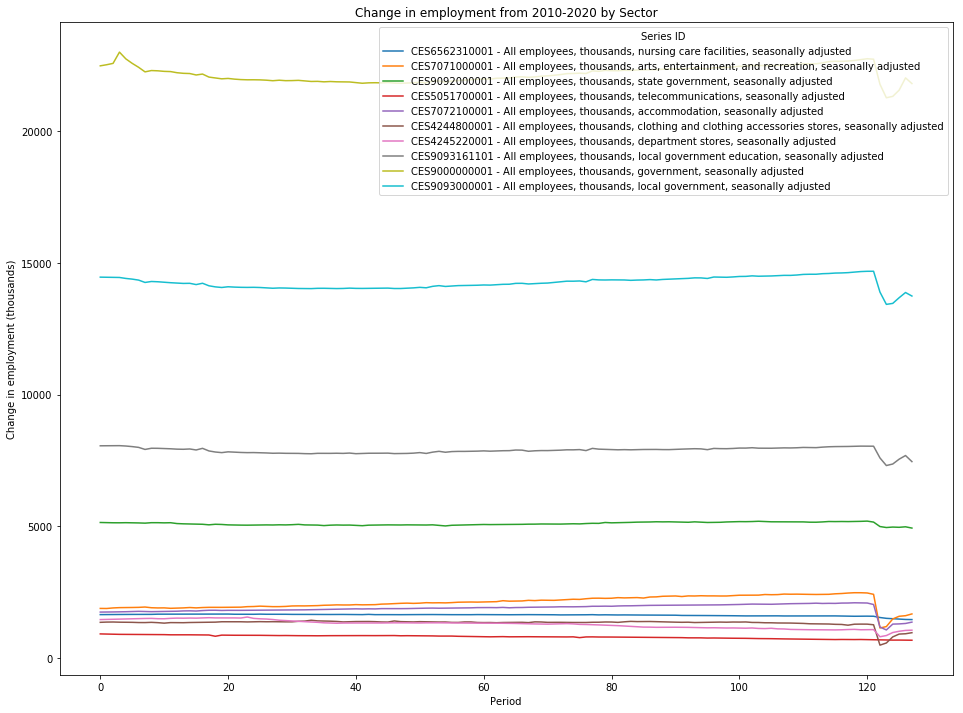

In [10]:
# Line Chart of Bottom 10 sectors of job gains/losses over the last decade

sector_series = all_series.iloc[1:, 1:].T

sector_series = sector_series.reset_index().rename(columns={'index': 'period'})

sector_series['period'] = [parser.parse(d) for d in sector_series['period']]

series_id_to_title_dict = {}
for col in sector_series.columns:
    if col in series_definitions.index:
        row = series_definitions.loc[col]
        series_id_to_title_dict[col] = f"{col} - {row['series_title']}"
        
# print(series_id_to_title_dict)

for col in sector_series.columns:
    if col == 'period':
        continue
    new_series = []
    for s in sector_series[col]:
        floats = re.findall(r'[\d\.\d]+', str(s))
        if floats:
            new_series.append(float(floats[0]))
        else:
            new_series.append(0)
    sector_series[col] = new_series
    
# Exclude All employees, thousands, total private, seasonally adjusted and All employees, thousands, private service-providing, seasonally adjusted
# series_id	supersector_code	industry_code	data_type_code	seasonal	series_title
# CES0500000001	5	5000000	1	S	All employees, thousands, total private, seasonally adjusted
# CES0800000001	8	8000000	1	S	All employees, thousands, private service-providing, seasonally adjusted
cols = [col for col in sector_series.columns if col not in ['CES0500000001', 'CES0800000001']]
sector_series = sector_series[cols]

sector_series = sector_series[(sector_series != 0).all(1)]

# last_row = sector_series.tail(1)
# last_row = last_row.set_index('period')
# last_row = last_row.sort_values(axis=1, by=last_row.index[0], ascending=False)

# top_10 = sector_series[list(last_row.columns)[-10:]]
top_10 = sector_series[list(most_jobs_lost.columns)]
# top_10 = top_10.set_index('period')
top_10 = top_10.rename(columns=series_id_to_title_dict)

ax = top_10.plot(rot=0, figsize=(16,12), title="Change in employment from 2010-2020 by Sector")
ax.set_ylabel("Change in employment (thousands)")
ax.set_xlabel("Period")

Text(0, 0.5, 'CES7072100001 - All employees, thousands, accommodation, seasonally adjusted')

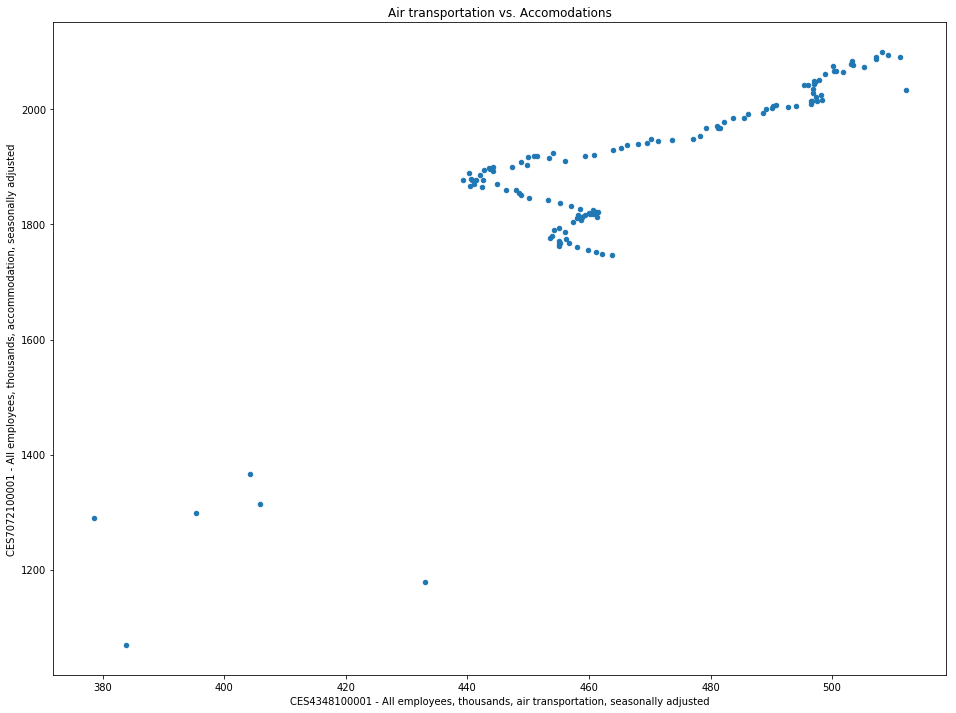

In [11]:
# See if there is a correlation between the employment levels of Airline Transportation and Accomodations

sector_series = all_series.iloc[1:, 1:].T

sector_series = sector_series.reset_index().rename(columns={'index': 'period'})

sector_series['period'] = [parser.parse(d) for d in sector_series['period']]

series_id_to_title_dict = {}
for col in sector_series.columns:
    if col in series_definitions.index:
        row = series_definitions.loc[col]
        series_id_to_title_dict[col] = f"{col} - {row['series_title']}"
        
# print(series_id_to_title_dict)

for col in sector_series.columns:
    if col == 'period':
        continue
    new_series = []
    for s in sector_series[col]:
        floats = re.findall(r'[\d\.\d]+', str(s))
        if floats:
            new_series.append(float(floats[0]))
        else:
            new_series.append(0)
    sector_series[col] = new_series
    
# series_id	supersector_code	industry_code	data_type_code	seasonal	series_title
# CES4348100001	43	43481000	1	S	All employees, thousands, air transportation, seasonally adjusted
# CES7072100001	70	70721000	1	S	All employees, thousands, accommodation, seasonally adjusted
cols = [col for col in sector_series.columns if col not in ['CES0500000001', 'CES0800000001']]
sector_series = sector_series[['CES4348100001', 'CES7072100001']]

sector_series = sector_series[(sector_series != 0).all(1)]


# Scatter plot
ax = sector_series.plot(kind='scatter', x='CES4348100001', y='CES7072100001', figsize=(16,12), title='Air transportation vs. Accomodations')
ax.set_xlabel(series_id_to_title_dict.get('CES4348100001'))
ax.set_ylabel(series_id_to_title_dict.get('CES7072100001'))

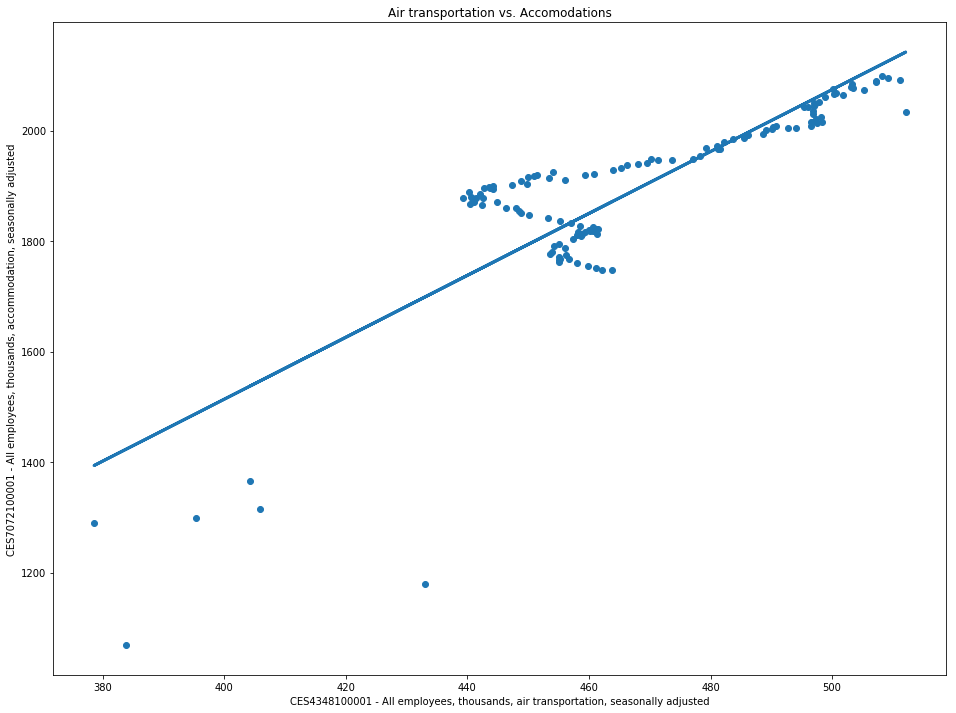

In [12]:
# Perform ordinary least squares and plot a trendline

sector_series = all_series.iloc[1:, 1:].T

sector_series = sector_series.reset_index().rename(columns={'index': 'period'})

sector_series['period'] = [parser.parse(d) for d in sector_series['period']]

series_id_to_title_dict = {}
for col in sector_series.columns:
    if col in series_definitions.index:
        row = series_definitions.loc[col]
        series_id_to_title_dict[col] = f"{col} - {row['series_title']}"
        
# print(series_id_to_title_dict)

for col in sector_series.columns:
    if col == 'period':
        continue
    new_series = []
    for s in sector_series[col]:
        floats = re.findall(r'[\d\.\d]+', str(s))
        if floats:
            new_series.append(float(floats[0]))
        else:
            new_series.append(0)
    sector_series[col] = new_series
    
# series_id	supersector_code	industry_code	data_type_code	seasonal	series_title
# CES4348100001	43	43481000	1	S	All employees, thousands, air transportation, seasonally adjusted
# CES7072100001	70	70721000	1	S	All employees, thousands, accommodation, seasonally adjusted
cols = [col for col in sector_series.columns if col not in ['CES0500000001', 'CES0800000001']]
sector_series = sector_series[['CES4348100001', 'CES7072100001']]

sector_series = sector_series[(sector_series != 0).all(1)]

from sklearn import datasets, linear_model
import matplotlib.pyplot as plt

x = sector_series[['CES4348100001']]
y = sector_series[['CES7072100001']]

regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(x, y)

# plot it as in the example at http://scikit-learn.org/
plt.figure(figsize=(16, 12))
plt.scatter(x, y)
plt.plot(x, regr.predict(x), linewidth=3)
plt.title('Air transportation vs. Accomodations')
plt.xlabel('CES4348100001 - All employees, thousands, air transportation, seasonally adjusted')
plt.ylabel('CES7072100001 - All employees, thousands, accommodation, seasonally adjusted')
plt.show()

In [13]:
print(regr.coef_)
print(regr.intercept_)

[[5.60434457]]
[-728.03142851]


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


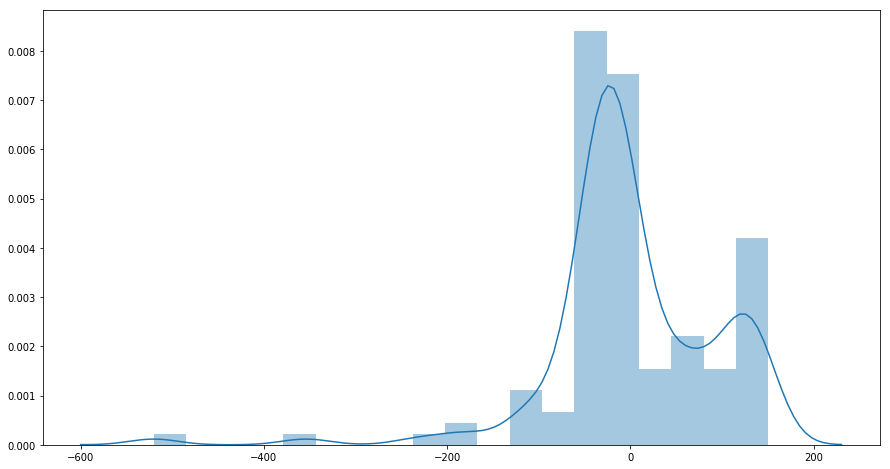

In [14]:
# Plot the average deviations from the predicted values

import seaborn as sns

plt.figure(figsize=(15,8))
sns.distplot(y - regr.predict(x))

In [15]:
# Use statsmodels to get predictive statistics

import statsmodels.api as sm

sector_series = all_series.iloc[1:, 1:].T

sector_series = sector_series.reset_index().rename(columns={'index': 'period'})

sector_series['period'] = [parser.parse(d) for d in sector_series['period']]

series_id_to_title_dict = {}
for col in sector_series.columns:
    if col in series_definitions.index:
        row = series_definitions.loc[col]
        series_id_to_title_dict[col] = f"{col} - {row['series_title']}"
        
# print(series_id_to_title_dict)

for col in sector_series.columns:
    if col == 'period':
        continue
    new_series = []
    for s in sector_series[col]:
        floats = re.findall(r'[\d\.\d]+', str(s))
        if floats:
            new_series.append(float(floats[0]))
        else:
            new_series.append(0)
    sector_series[col] = new_series
    
# series_id	supersector_code	industry_code	data_type_code	seasonal	series_title
# CES4348100001	43	43481000	1	S	All employees, thousands, air transportation, seasonally adjusted
# CES7072100001	70	70721000	1	S	All employees, thousands, accommodation, seasonally adjusted
cols = [col for col in sector_series.columns if col not in ['CES0500000001', 'CES0800000001']]
sector_series = sector_series[['CES4348100001', 'CES7072100001']]

sector_series = sector_series[(sector_series != 0).all(1)]

X = sector_series[['CES4348100001']]
y = sector_series[['CES7072100001']]

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
print(results.pvalues)

                            OLS Regression Results                            
Dep. Variable:          CES7072100001   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     312.4
Date:                Thu, 22 Oct 2020   Prob (F-statistic):           6.44e-36
Time:                        20:09:42   Log-Likelihood:                -761.75
No. Observations:                 128   AIC:                             1528.
Df Residuals:                     126   BIC:                             1533.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -728.0314    148.265     -4.910

In [16]:
# How strong the correlation between two metrics that were explained in the question?

"""
Based on the output of the Linear Regression there is a statistically significant relationship (P>|t| is less than 0.05)
between the level of employment for Air transportation and for Accomodates. Both the intercept and slope
of the regression are significant according to the statsmodels ols regression. 

For every ~5.6k workers in Accomodations there will be ~1k in Air travel. This sort of makes intuitive sense because
it takes more people to run hotels than it does to run an airport and airplane. 

The y-intercept also seems to suggest that without an Air transportation industry there would still be people
working in accomodations. Before Air transportation the car was the biggest means to get around and this
also can make some intuitive sense
"""

'\nBased on the output of the Linear Regression there is a statistically significant relationship (P>|t| is less than 0.05)\nbetween the level of employment for Air transportation and for Accomodates. Both the intercept and slope\nof the regression are significant according to the statsmodels ols regression. \n\nFor every ~5.6k workers in Accomodations there will be ~1k in Air travel. This sort of makes intuitive sense because\nit takes more people to run hotels than it does to run an airport and airplane. \n\nThe y-intercept also seems to suggest that without an Air transportation industry there would still be people\nworking in accomodations. Before Air transportation the car was the biggest means to get around and this\nalso can make some intuitive sense\n'

In [17]:
# What is your inference about the output of your study?

"""
This capstone suggests that there is a statistically significant relationship between the level of employment in
Air transportation and in Accomodations. 

I think it makes intuitive sense that these industries are strongly correlated. After all, air travelers need hotels
and other accomodations to stay in while traveling. 

In the following cells I want to examine other industries and how they relate.
"""

'\nThis capstone suggests that there is a statistically significant relationship between the level of employment in\nAir transportation and in Accomodations. \n\nI think it makes intuitive sense that these industries are strongly correlated. After all, air travelers need hotels\nand other accomodations to stay in while traveling. \n\nIn the following cells I want to examine other industries and how they relate.\n'

In [35]:
# Find the 2 pairwise series with the lowest OLS Slope

import statsmodels.api as sm
import itertools
import math

sector_series = all_series.iloc[1:, 1:].T

sector_series = sector_series.reset_index().rename(columns={'index': 'period'})

sector_series['period'] = [parser.parse(d) for d in sector_series['period']]

series_id_to_title_dict = {}
for col in sector_series.columns:
    if col in series_definitions.index:
        row = series_definitions.loc[col]
        series_id_to_title_dict[col] = f"{col} - {row['series_title']}"
        
# print(series_id_to_title_dict)

for col in sector_series.columns:
    if col == 'period':
        continue
    new_series = []
    for s in sector_series[col]:
        floats = re.findall(r'[\d\.\d]+', str(s))
        if floats:
            new_series.append(float(floats[0]))
        else:
            new_series.append(0)
    sector_series[col] = new_series
    
cols = [col for col in sector_series.columns if col not in ['period']]
sector_series = sector_series[cols]
sector_series = sector_series[(sector_series != 0).all(1)]

all_pairs = list(itertools.combinations(cols, 2))

# print(all_pairs)

all_slopes = []
min_slope = math.inf
idx_min = -1
for idx, pair in enumerate(all_pairs):
    X = sector_series[[pair[0]]]
    y = sector_series[[pair[1]]]

    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    slope = results.params[pair[0]]
    if slope < min_slope:
        idx_min = idx
        min_slope = slope
    all_slopes.append(slope)
    

print('\n')
print(idx_min)
print(min_slope)
if idx_min > -1:
    print(all_pairs[idx_min])



12636
-1998.652504388584
('CES5553300001', 'CES6000000001')


In [38]:
sorted_pairs = [x for _, x in sorted(zip(all_slopes, all_pairs))]
sorted_slopes = [x for x, _ in sorted(zip(all_slopes, all_pairs))]

print(sorted_slopes[0:10])
print(sorted_pairs[0])

[-1998.652504388584, -1831.0484927332204, -1590.6043458114682, -1390.4441546511825, -1100.7582091015227, -1082.3048751147267, -953.656327134368, -943.8627554066463, -905.1607246286412, -790.2562041649219]
('CES5553300001', 'CES6000000001')


Text(0, 0.5, 'All employees, thousands, private service-providing, seasonally adjusted')

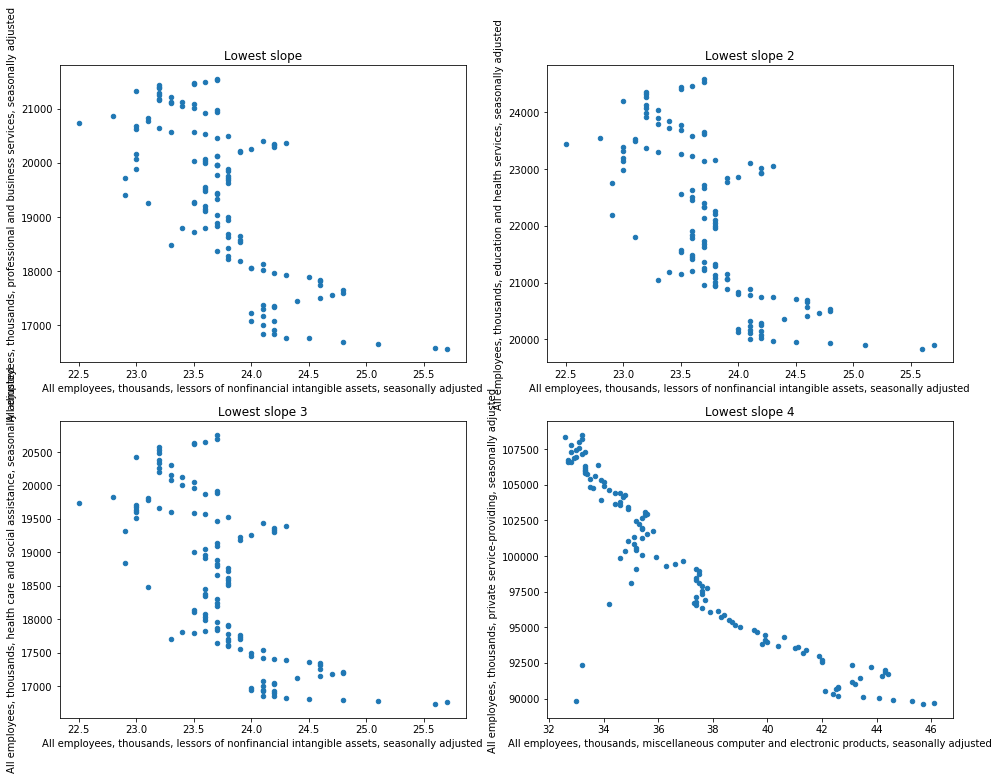

In [47]:
sector_series = all_series.iloc[1:, 1:].T

sector_series = sector_series.reset_index().rename(columns={'index': 'period'})

sector_series['period'] = [parser.parse(d) for d in sector_series['period']]

series_id_to_title_dict = {}
for col in sector_series.columns:
    if col in series_definitions.index:
        row = series_definitions.loc[col]
        series_id_to_title_dict[col] = f"{row['series_title']}"
        
# print(series_id_to_title_dict)

for col in sector_series.columns:
    if col == 'period':
        continue
    new_series = []
    for s in sector_series[col]:
        floats = re.findall(r'[\d\.\d]+', str(s))
        if floats:
            new_series.append(float(floats[0]))
        else:
            new_series.append(0)
    sector_series[col] = new_series
    
sector_series = sector_series[(sector_series != 0).all(1)]
    
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))

series1 = sector_series[list(sorted_pairs[0])]
series2 = sector_series[list(sorted_pairs[1])]
series3 = sector_series[list(sorted_pairs[2])]
series4 = sector_series[list(sorted_pairs[3])]

# Scatter plot
ax1 = series1.plot(kind='scatter', x=list(sorted_pairs[0])[0], y=list(sorted_pairs[0])[1], figsize=(16,12), title='Lowest slope', ax=axes[0,0])
ax1.set_xlabel(series_id_to_title_dict.get(list(sorted_pairs[0])[0]))
ax1.set_ylabel(series_id_to_title_dict.get(list(sorted_pairs[0])[1]))

ax2 = series2.plot(kind='scatter', x=list(sorted_pairs[1])[0], y=list(sorted_pairs[1])[1], figsize=(16,12), title='Lowest slope 2', ax=axes[0,1])
ax2.set_xlabel(series_id_to_title_dict.get(list(sorted_pairs[1])[0]))
ax2.set_ylabel(series_id_to_title_dict.get(list(sorted_pairs[1])[1]))

ax3 = series3.plot(kind='scatter', x=list(sorted_pairs[2])[0], y=list(sorted_pairs[2])[1], figsize=(16,12), title='Lowest slope 3', ax=axes[1,0])
ax3.set_xlabel(series_id_to_title_dict.get(list(sorted_pairs[2])[0]))
ax3.set_ylabel(series_id_to_title_dict.get(list(sorted_pairs[2])[1]))

ax4 = series4.plot(kind='scatter', x=list(sorted_pairs[3])[0], y=list(sorted_pairs[3])[1], figsize=(16,12), title='Lowest slope 4', ax=axes[1,1])
ax4.set_xlabel(series_id_to_title_dict.get(list(sorted_pairs[3])[0]))
ax4.set_ylabel(series_id_to_title_dict.get(list(sorted_pairs[3])[1]))


In [54]:
# Same analysis, but only using sectors that employ an average a 2.5 million or more people

sector_series = all_series.iloc[1:, 1:].T

sector_series = sector_series.reset_index().rename(columns={'index': 'period'})

sector_series['period'] = [parser.parse(d) for d in sector_series['period']]

series_id_to_title_dict = {}
for col in sector_series.columns:
    if col in series_definitions.index:
        row = series_definitions.loc[col]
        series_id_to_title_dict[col] = f"{row['series_title']}"
        
# print(series_id_to_title_dict)

for col in sector_series.columns:
    if col == 'period':
        continue
    new_series = []
    for s in sector_series[col]:
        floats = re.findall(r'[\d\.\d]+', str(s))
        if floats:
            new_series.append(float(floats[0]))
        else:
            new_series.append(0)
    sector_series[col] = new_series
    
sector_series = sector_series[(sector_series != 0).all(1)]
sector_series = sector_series[[col for col in sector_series.columns if col != 'period']]

sector_series = sector_series[sector_series.columns[sector_series.mean(axis=0) > 2500]]

all_pairs = list(itertools.combinations(list(sector_series.columns), 2))

# print(all_pairs)

all_slopes = []
min_slope = math.inf
idx_min = -1
for idx, pair in enumerate(all_pairs):
    X = sector_series[[pair[0]]]
    y = sector_series[[pair[1]]]

    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    slope = results.params[pair[0]]
    if slope < min_slope:
        idx_min = idx
        min_slope = slope
    all_slopes.append(slope)

In [55]:
sorted_pairs = [x for _, x in sorted(zip(all_slopes, all_pairs))]
sorted_slopes = [x for x, _ in sorted(zip(all_slopes, all_pairs))]

print(sorted_slopes[0:10])
print(sorted_pairs[0])

[-0.8352474140566466, -0.5243982043991322, -0.46485475745021476, -0.4507745433785264, -0.3351640232394454, -0.294391052356449, -0.28806915740203753, -0.27769482150586783, -0.2350948898970297, -0.23129591984488673]
('CES4245200001', 'CES9000000001')


Text(0, 0.5, 'All employees, thousands, federal, seasonally adjusted')

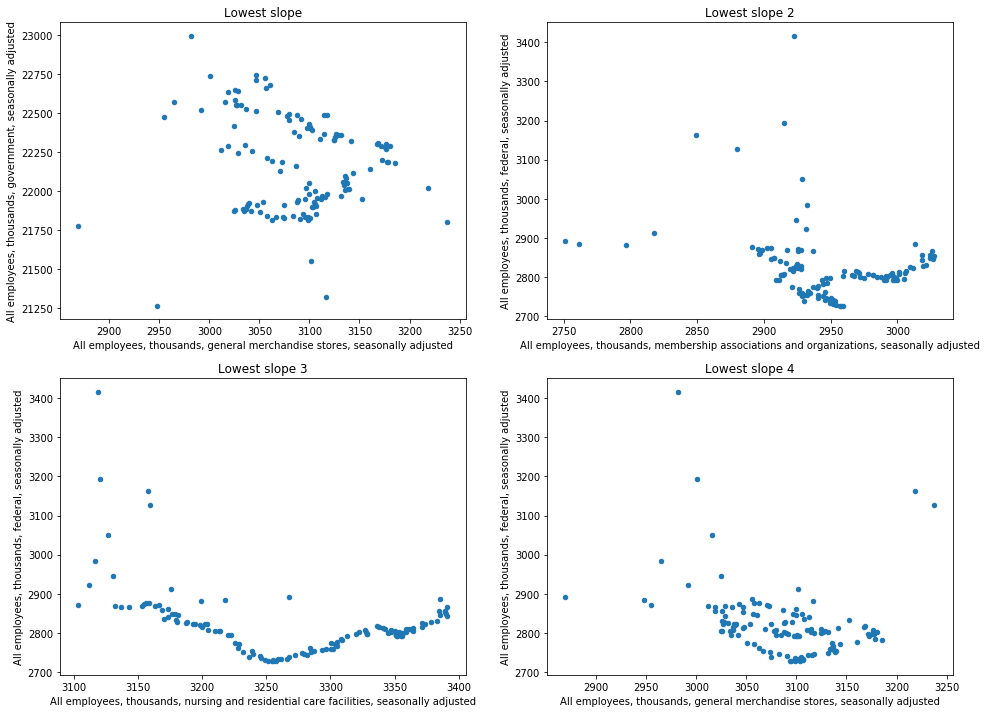

In [56]:
sector_series = all_series.iloc[1:, 1:].T

sector_series = sector_series.reset_index().rename(columns={'index': 'period'})

sector_series['period'] = [parser.parse(d) for d in sector_series['period']]

series_id_to_title_dict = {}
for col in sector_series.columns:
    if col in series_definitions.index:
        row = series_definitions.loc[col]
        series_id_to_title_dict[col] = f"{row['series_title']}"
        
# print(series_id_to_title_dict)

for col in sector_series.columns:
    if col == 'period':
        continue
    new_series = []
    for s in sector_series[col]:
        floats = re.findall(r'[\d\.\d]+', str(s))
        if floats:
            new_series.append(float(floats[0]))
        else:
            new_series.append(0)
    sector_series[col] = new_series
    
sector_series = sector_series[(sector_series != 0).all(1)]
    
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))

series1 = sector_series[list(sorted_pairs[0])]
series2 = sector_series[list(sorted_pairs[1])]
series3 = sector_series[list(sorted_pairs[2])]
series4 = sector_series[list(sorted_pairs[3])]

# Scatter plot
ax1 = series1.plot(kind='scatter', x=list(sorted_pairs[0])[0], y=list(sorted_pairs[0])[1], figsize=(16,12), title='Lowest slope', ax=axes[0,0])
ax1.set_xlabel(series_id_to_title_dict.get(list(sorted_pairs[0])[0]))
ax1.set_ylabel(series_id_to_title_dict.get(list(sorted_pairs[0])[1]))

ax2 = series2.plot(kind='scatter', x=list(sorted_pairs[1])[0], y=list(sorted_pairs[1])[1], figsize=(16,12), title='Lowest slope 2', ax=axes[0,1])
ax2.set_xlabel(series_id_to_title_dict.get(list(sorted_pairs[1])[0]))
ax2.set_ylabel(series_id_to_title_dict.get(list(sorted_pairs[1])[1]))

ax3 = series3.plot(kind='scatter', x=list(sorted_pairs[2])[0], y=list(sorted_pairs[2])[1], figsize=(16,12), title='Lowest slope 3', ax=axes[1,0])
ax3.set_xlabel(series_id_to_title_dict.get(list(sorted_pairs[2])[0]))
ax3.set_ylabel(series_id_to_title_dict.get(list(sorted_pairs[2])[1]))

ax4 = series4.plot(kind='scatter', x=list(sorted_pairs[3])[0], y=list(sorted_pairs[3])[1], figsize=(16,12), title='Lowest slope 4', ax=axes[1,1])
ax4.set_xlabel(series_id_to_title_dict.get(list(sorted_pairs[3])[0]))
ax4.set_ylabel(series_id_to_title_dict.get(list(sorted_pairs[3])[1]))
